In [3]:
#@title Autoload all modules
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import importlib
import os
import functools
import itertools
import torch
from losses import get_optimizer
from models.ema import ExponentialMovingAverage
import torch.nn as nn
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_gan as tfgan
import tqdm
import io

from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnv2
from models import ncsnpp
from models import ddpm as ddpm_model
from models import layerspp
from models import layers
from models import normalization
import sampling2_parallel


from sde_lib import VESDE, VPSDE, subVPSDE

from sampling2_parallel import (ReverseDiffusionPredictor, 
                      LangevinCorrector,
                      NoneCorrector, 
                      NonePredictor)
                      


def get_data_scaler(config):
  """Data normalizer. Assume data are always in [0, 1]."""
  if config.data.centered:
    # Rescale to [-1, 1]
    return lambda x: x * 2. - 1.
  else:
    return lambda x: x


def get_data_inverse_scaler(config):
  """Inverse data normalizer."""
  if config.data.centered:
    # Rescale [-1, 1] to [0, 1]
    return lambda x: (x + 1.) / 2.
  else:
    return lambda x: x



def show_samples(x):
  plt.figure(figsize=(8,8))
  plt.axis('off')
  plt.imshow(abs(x),cmap='gray')
  plt.show()





In [4]:
# @title Load the HKGM model
sde = 'VESDE' 
if sde.lower() == 'vesde':
  from configs.ve import SIAT_kdata_ncsnpp_test as configs  
  model_num = 'checkpoint.pth'
  ckpt_filename ='./exp/checkpoints/checkpoint_15.pth'  
  config = configs.get_config()  
  sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales) ###################################  sde
  sampling_eps = 1e-5


batch_size = 12 #@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = get_data_scaler(config)
inverse_scaler = get_data_inverse_scaler(config)
score_model = mutils.create_model(config)
optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

In [5]:
#@title reconstruction
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.075#0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling2_parallel.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x= sampling_fn(score_model)

0.2504119873046875
1.2473874
psnr_zero:  27.688978570504684 ssim_zero:  0.880797613282437
========  0
 PSNR: 28.445524958739895  SSIM: 0.8951003920464643


(256, 256) float32


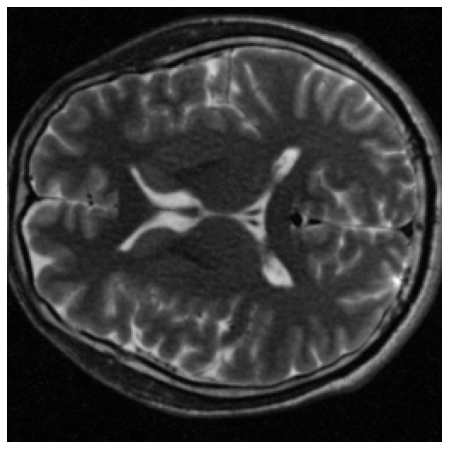

In [6]:
#@title show reconstruction image
print(x.shape,x.dtype)
show_samples(x)